In [242]:
import pandas as pd


In [243]:
data = pd.read_csv("./amazon_prime_titles.csv")

In [244]:
data.shape

(9668, 12)

In [245]:
data["rating"]

0         NaN
1         13+
2         NaN
3         NaN
4         NaN
        ...  
9663       7+
9664      13+
9665        R
9666    TV-MA
9667        R
Name: rating, Length: 9668, dtype: object

In [246]:
data.isnull().sum()

show_id            0
type               0
title              0
director        2082
cast            1233
country         8996
date_added      9513
release_year       0
rating           337
duration           0
listed_in          0
description        0
dtype: int64

In [247]:
import numpy as np

#### My Hypothesis is that most directors only direct similar movies. Similar movies are known from their description and their rating

In [248]:
data = data.dropna(subset=['director']).reset_index(drop=True)

In [249]:
data.shape


(7586, 12)

In [250]:
data.isnull().sum()

show_id            0
type               0
title              0
director           0
cast             634
country         7017
date_added      7570
release_year       0
rating           330
duration           0
listed_in          0
description        0
dtype: int64

In [251]:
data = data[["type", "title", "director", "cast", "country", "rating", "duration", "description"]]

In [252]:
data.head()

,type,title,director,cast,country,rating,duration,description
0,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,NaN,113 min,A small fishing village must procure a local d...
1,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,13+,110 min,A Metro Family decides to fight a Cyber Crimin...
2,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,NaN,74 min,After a man discovers his wife is cheating on ...
3,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,NaN,69 min,"Pink breaks the mold once again, bringing her ..."
4,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,NaN,45 min,Teenage Matt Banting wants to work with a famo...


In [253]:
data["rating"].fillna("All", inplace=True)


In [254]:
data.head()

,type,title,director,cast,country,rating,duration,description
0,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,All,113 min,A small fishing village must procure a local d...
1,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,13+,110 min,A Metro Family decides to fight a Cyber Crimin...
2,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,All,74 min,After a man discovers his wife is cheating on ...
3,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,All,69 min,"Pink breaks the mold once again, bringing her ..."
4,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,All,45 min,Teenage Matt Banting wants to work with a famo...


In [255]:
sameRated = data[data[["director", "rating"]].nunique(axis=1) == 1]

In [256]:
sameRated

,type,title,director,cast,country,rating,duration,description


In [257]:
print(data["director"].nunique())
print(data.shape)

5774
(7586, 8)


#### This hypothesis didn't work out. My next hypothesis is similarly described movies have similar ratings. 

#### To determine similarity between movies description using NLTK library. 

In [258]:
import numpy as np

In [259]:
import sys
!{sys.executable} -m pip install nltk

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [260]:
import nltk

In [261]:
!{sys.executable} -m pip install numpy==1.22.4

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached numpy-1.22.4-cp39-cp39-macosx_11_0_arm64.whl (12.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/766

In [262]:
import re

In [263]:
data["description"] = data["description"].astype('str')

In [264]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=False)
def normalize(X): 
  normalized = []
  for x in X:
    words = nltk.word_tokenize(x)
    normalized.append(' '.join([stemmer.stem(word) for word in words if re.match('[a-zA-Z]+', word)]))
  return normalized


In [265]:
!{sys.executable} -m pip install --upgrade --force-reinstall scikit-learn

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer

toTrain = Pipeline([
  ('normalize', FunctionTransformer(normalize, validate=False)),
  ('counter_vectorizer', CountVectorizer(max_df=0.9, max_features=200000,min_df=0.1, stop_words='english',ngram_range=(1,3)
  )),
  ('tfidf_transform', TfidfTransformer())
])

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached scikit_learn-1.1.3-cp39-cp39-macosx_12_0_arm64.whl (7.7 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached scipy-1.9.3-cp39-cp39-macosx_12_0_arm64.whl (28.6 MB)
  Using cached numpy-1.23.5-cp39-cp39-macosx_11_0_arm64.whl (13.4 MB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.1.0
    Uninstalling threadpoolctl-3.1.0:
      Successfully uninstalled threadpoolctl-3.1.0
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebr

In [266]:
from sklearn.metrics.pairwise import cosine_similarity 

tfidf_matrix = pipe.fit_transform([desc for desc in data['description']])
similarity_matrix = 1 - cosine_similarity(tfidf_matrix)

In [267]:
print(similarity_matrix)
print(similarity_matrix.shape)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(7586, 7586)


In [268]:
# Percentage of articles that are much different from each other
new = similarity_matrix.argsort(axis=1)


In [269]:
def getPredictedRating(title):
    givenIndex = data[data["title"] == title].index[0]
    ourCol = new[givenIndex, :]
    needed = ourCol[1:4]
    allRatings = []
    for index in needed:
        allRatings.append(data.iloc[index]["rating"])
    new_dict = {}
    for ele in allRatings:
        if ele in new_dict:
            new_dict[ele] += 1
        else:
            new_dict[ele] = 1
    counts = list(new_dict.values())
    if counts == [1, 1, 1]:
        return allRatings[0]
    for k, v in new_dict.items():
        if v != 1:
            return k


In [270]:
data["rating"].unique()

array(['All', '13+', 'R', 'NR', 'ALL', '18+', 'PG-13', '16+', '7+', 'G',
       'PG', 'NC-17', 'UNRATED', '16', 'AGES_16_', 'AGES_18_', 'ALL_AGES',
       'NOT_RATE'], dtype=object)

In [271]:
replace_dict = {"ALL_AGES": "All", "NOT_RATE": "All","ALL": "All", "PG-13": "13+", "NC-17": "17+", "UNRATED": "All", "16": "16+", "AGES_16_": "16+", "AGES_18_": "18+"}

In [272]:
data = data.replace({"rating": replace_dict})

In [273]:
data["rating"].unique()

array(['All', '13+', 'R', 'NR', '18+', '16+', '7+', 'G', 'PG', '17+'],
      dtype=object)

In [274]:
print(getPredictedRating("Wilder Napalm"))

13+


In [275]:
!{sys.executable} -m pip install swifter

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [276]:
import swifter

In [277]:
data["PredictedRating"] = data["title"].swifter.apply(getPredictedRating)

Pandas Apply:   0%|          | 0/7586 [00:00<?, ?it/s]

In [278]:
data

,type,title,director,cast,country,rating,duration,description,PredictedRating
0,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,All,113 min,A small fishing village must procure a local d...,13+
1,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,13+,110 min,A Metro Family decides to fight a Cyber Crimin...,13+
2,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,All,74 min,After a man discovers his wife is cheating on ...,13+
3,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,All,69 min,"Pink breaks the mold once again, bringing her ...",13+
4,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,All,45 min,Teenage Matt Banting wants to work with a famo...,13+
...,...,...,...,...,...,...,...,...,...
7581,Movie,The Man in the Hat,"John-Paul Davidson, Stephen Warbeck","Ciaran Hinds, Stephen Dillane, Maïwenn",NaN,13+,96 min,The Man in the Hat journeys through France in ...,13+
7582,Movie,River,Emily Skye,"Mary Cameron Rogers, Alexandra Rose, Rob Marsh...",NaN,16+,93 min,"River is a grounded Sci-Fi mystery Thriller, t...",13+
7583,Movie,Pride Of The Bowery,Joseph H. Lewis,"Leo Gorcey, Bobby Jordan",NaN,7+,60 min,New York City street principles get an East Si...,13+
7584,Movie,Outpost,Steve Barker,"Ray Stevenson, Julian Wadham, Richard Brake, M...",NaN,R,90 min,"In war-torn Eastern Europe, a world-weary grou...",13+


In [279]:
shape = data["rating"].nunique()
uniqueRatings = np.zeros((shape,shape))

In [280]:
data["rating"].unique()

array(['All', '13+', 'R', 'NR', '18+', '16+', '7+', 'G', 'PG', '17+'],
      dtype=object)

In [281]:
print(uniqueRatings)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [282]:
ourDict = {"All": 0, "13+": 1, "R": 2, "NR": 3, "18+": 4, "16+": 5, "7+": 6, "G": 7, "PG": 8, "17+": 9}

In [283]:
for i in range(len(data)):
    real = data.iloc[i]["rating"]
    predicted = data.iloc[i]["PredictedRating"]
    uniqueRatings[ourDict[real]][ourDict[predicted]] += 1


In [284]:
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt


In [285]:
ratingsList = list(data["rating"].unique())

In [286]:
ratingsList


['All', '13+', 'R', 'NR', '18+', '16+', '7+', 'G', 'PG', '17+']

In [287]:
print(uniqueRatings)


[[9.000e+00 1.039e+03 1.010e+02 0.000e+00 4.600e+01 3.000e+00 0.000e+00
  0.000e+00 2.200e+01 0.000e+00]
 [8.000e+00 1.754e+03 2.090e+02 1.000e+00 1.940e+02 1.300e+01 0.000e+00
  0.000e+00 5.700e+01 0.000e+00]
 [2.000e+00 8.000e+02 1.060e+02 0.000e+00 7.200e+01 4.000e+00 0.000e+00
  0.000e+00 1.600e+01 0.000e+00]
 [0.000e+00 1.010e+02 1.400e+01 1.000e+00 1.000e+01 0.000e+00 0.000e+00
  0.000e+00 6.000e+00 0.000e+00]
 [2.000e+00 8.300e+02 1.370e+02 0.000e+00 1.050e+02 4.000e+00 0.000e+00
  0.000e+00 1.800e+01 0.000e+00]
 [3.000e+00 9.860e+02 1.270e+02 0.000e+00 1.200e+02 1.200e+01 0.000e+00
  0.000e+00 2.400e+01 0.000e+00]
 [1.000e+00 2.370e+02 2.100e+01 0.000e+00 2.000e+01 3.000e+00 0.000e+00
  0.000e+00 4.000e+00 0.000e+00]
 [0.000e+00 7.100e+01 1.000e+01 0.000e+00 9.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 1.960e+02 2.600e+01 0.000e+00 2.100e+01 0.000e+00 0.000e+00
  0.000e+00 8.000e+00 0.000e+00]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.0

In [288]:
import seaborn as sns


# x-axis are the real ratings while the y-axis has predicted ratings values

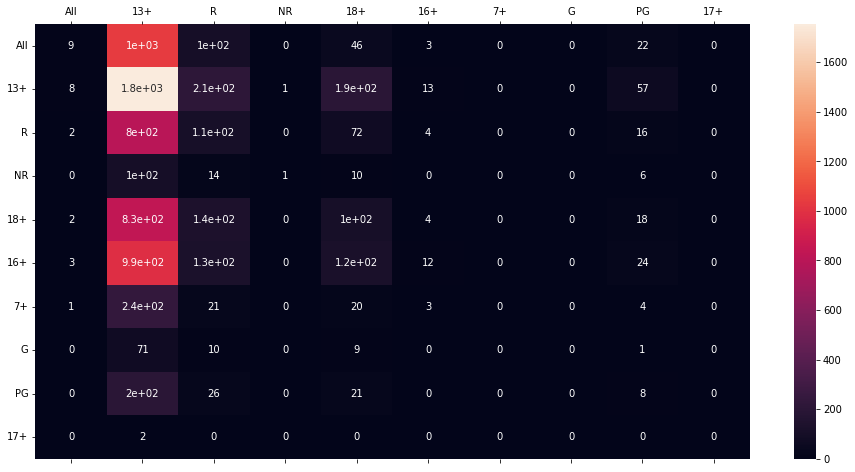

In [289]:
plt.figure(figsize = (16,8))
plt.xlabel("Predicted Ratings")
plt.ylabel("Real Ratings")
ax = sns.heatmap(uniqueRatings, annot = True, xticklabels = ratingsList, yticklabels=ratingsList)
ax.tick_params(right=False, top=True, labelright=False, bottom = "False", labelbottom = False, labeltop=True, labelrotation=0)
plt.show()

<AxesSubplot: xlabel='rating'>

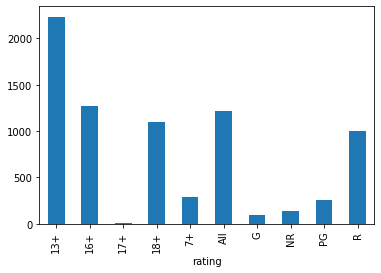

In [290]:
(data.groupby('rating')
   ['title'].nunique()
   .plot.bar()
)

In [291]:
def getPredictedRating_1k(title):
    givenIndex = data[data["title"] == title].index[0]
    ourCol = new[givenIndex, :]
    needed = ourCol[1]
    return data.iloc[needed]["rating"]

In [292]:
data["PredictedRating_1k"] = data["title"].swifter.apply(getPredictedRating_1k)

Pandas Apply:   0%|          | 0/7586 [00:00<?, ?it/s]

In [293]:
data

,type,title,director,cast,country,rating,duration,description,PredictedRating,PredictedRating_1k
0,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,All,113 min,A small fishing village must procure a local d...,13+,16+
1,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,13+,110 min,A Metro Family decides to fight a Cyber Crimin...,13+,16+
2,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,All,74 min,After a man discovers his wife is cheating on ...,13+,16+
3,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,All,69 min,"Pink breaks the mold once again, bringing her ...",13+,16+
4,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,All,45 min,Teenage Matt Banting wants to work with a famo...,13+,16+
...,...,...,...,...,...,...,...,...,...,...
7581,Movie,The Man in the Hat,"John-Paul Davidson, Stephen Warbeck","Ciaran Hinds, Stephen Dillane, Maïwenn",NaN,13+,96 min,The Man in the Hat journeys through France in ...,13+,16+
7582,Movie,River,Emily Skye,"Mary Cameron Rogers, Alexandra Rose, Rob Marsh...",NaN,16+,93 min,"River is a grounded Sci-Fi mystery Thriller, t...",13+,16+
7583,Movie,Pride Of The Bowery,Joseph H. Lewis,"Leo Gorcey, Bobby Jordan",NaN,7+,60 min,New York City street principles get an East Si...,13+,16+
7584,Movie,Outpost,Steve Barker,"Ray Stevenson, Julian Wadham, Richard Brake, M...",NaN,R,90 min,"In war-torn Eastern Europe, a world-weary grou...",13+,16+


In [294]:
onekHeatmap = np.zeros((shape, shape))

In [295]:
for i in range(len(data)):
    real = data.iloc[i]["rating"]
    predicted = data.iloc[i]["PredictedRating_1k"]
    onekHeatmap[ourDict[real]][ourDict[predicted]] += 1

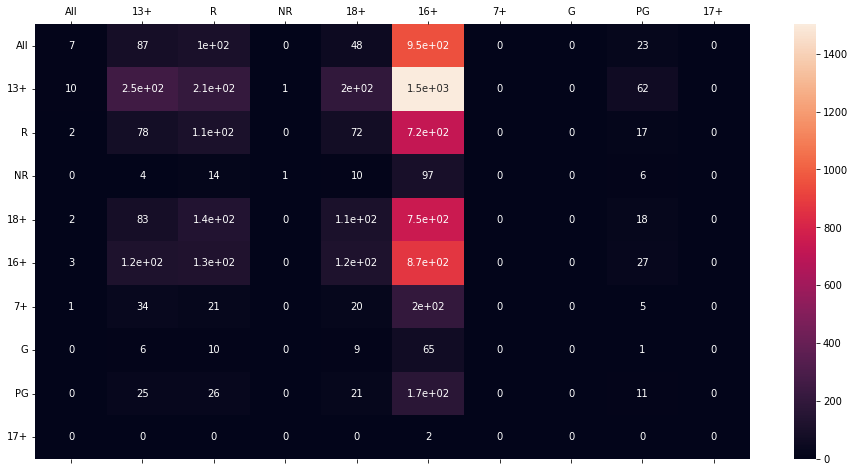

In [296]:
plt.figure(figsize = (16,8))
ax = sns.heatmap(onekHeatmap, annot = True, xticklabels = ratingsList, yticklabels=ratingsList)
ax.tick_params(right=False, top=True, labelright=False, bottom = "False", labelbottom = False, labeltop=True, labelrotation=0)
plt.show()

In [298]:
from sklearn.metrics import classification_report, confusion_matrix

In [299]:
c = confusion_matrix(data["rating"], data["PredictedRating_1k"])

In [300]:
c


array([[ 254, 1503,    0,  196,    0,   10,    0,    1,   62,  210],
       [ 123,  872,    0,  120,    0,    3,    0,    0,   27,  127],
       [   0,    2,    0,    0,    0,    0,    0,    0,    0,    0],
       [  83,  749,    0,  107,    0,    2,    0,    0,   18,  137],
       [  34,  205,    0,   20,    0,    1,    0,    0,    5,   21],
       [  87,  954,    0,   48,    0,    7,    0,    0,   23,  101],
       [   6,   65,    0,    9,    0,    0,    0,    0,    1,   10],
       [   4,   97,    0,   10,    0,    0,    0,    1,    6,   14],
       [  25,  168,    0,   21,    0,    0,    0,    0,   11,   26],
       [  78,  725,    0,   72,    0,    2,    0,    0,   17,  106]])